# 1. Preparação do notebook

In [1]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import warnings
import matplotlib.pyplot as plt

In [2]:
# Oculta avisos específicos do NumPy
warnings.filterwarnings("ignore", category=UserWarning, module="numpy")

# 2. Leitura dos dados

In [3]:
# Abertura da caixa de diálogo para selecionar o arquivo
uploaded = files.upload()

# Obtenção do nome do arquivo selecionado
filename = list(uploaded.keys())[0]

# Leitura do arquivo para um DataFrame
df = pd.read_excel(filename)

df.head()

Saving [BM Jumps 1] Séries temporais.xlsx to [BM Jumps 1] Séries temporais.xlsx


,bm_jumps_1_W,bm_jumps_1_MA,bm_jumps_1_KS,bm_jumps_1_SES,bm_jumps_1_QES,bm_jumps_1_SPLINES,bm_jumps_1_LOWESS,bm_jumps_1_RF,bm_jumps_1_KALMAN
0,0.496714,NaN,2.009838,0.496714,0.358450,0.496710,-9.903648,0.496714,0.496714
1,0.358450,NaN,-4.479763,0.496714,0.265813,0.358484,-9.885946,0.455235,0.413756
2,1.006138,NaN,-24.637139,0.455235,0.162267,1.005977,-9.868145,0.620506,0.778299
3,-9.844037,NaN,-19.806323,0.620506,0.309407,-135.982152,-9.850246,-40.360482,-83.691785
4,105.096588,1.337097,24.041033,-40.360482,-44.773039,140.804575,-9.832246,13.989754,55.043402


# 3. Previsão da série temporal

## 3.1. Criação de janelas deslizantes

In [4]:
# Função para criar janelas deslizantes
def create_sliding_windows(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

In [5]:
# Seleção da série
series = df['bm_jumps_1_SPLINES'].values

# Criação da janela deslizante
window_size = 1
X, y = create_sliding_windows(series, window_size)

In [6]:
X

array([[   0.49671003],
       [   0.35848396],
       [   1.00597669],
       ...,
       [ -28.63059332],
       [ -29.95147167],
       [-167.69202664]])

In [7]:
y

array([   0.35848396,    1.00597669, -135.98215162, ...,  -29.95147167,
       -167.69202664,  -29.17895993])

## 3.2. Normalização

In [8]:
# Função para normalização Min-Max
def normalize_series(series):
    scaler = RobustScaler()
    series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    return series_scaled, scaler

In [9]:
# Normalização dos dados
X_scaled, scaler_X = normalize_series(X.flatten())
y_scaled, scaler_y = normalize_series(y)

X_scaled = X_scaled.reshape(-1, window_size)

## 3.2. Treinamento do modelo

In [10]:
# Função para treinar XGBoost com otimização de hiperparâmetros
def train_xgb(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
    model = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    model.fit(X_train, y_train)
    print("Melhores hiperparâmetros:", model.best_params_)
    return model.best_estimator_

In [11]:
# Divisão entre treino e teste (70% treino, 30% teste)
split_idx = int(0.7 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# Treinamento do modelo XGBoost
xgb_model = train_xgb(X_train, y_train)

Melhores hiperparâmetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


## 3.3. Avaliação do modelo

In [12]:
# Fazer previsões no conjunto de treino
y_train_pred_scaled = xgb_model.predict(X_train).flatten()
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

# Fazer previsões no conjunto de teste
y_test_pred_scaled = xgb_model.predict(X_test).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Criar DataFrames com previsões
train_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten(),
                              'Predicted': y_train_pred})

test_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(),
                             'Predicted': y_test_pred})

In [13]:
# Cálculo do sMAPE
def smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

smape_train = smape(train_results['Actual'].values, train_results['Predicted'].values)
smape_test = smape(test_results['Actual'].values, test_results['Predicted'].values)

print(f'sMAPE Treino: {smape_train:.2f}%')
print(f'sMAPE Teste: {smape_test:.2f}%')

sMAPE Treino: 48.83%
sMAPE Teste: 54.90%


In [14]:
# Cálculo do RMSE
def rmse(actual, predicted):
    return np.sqrt(np.mean((predicted - actual) ** 2))

rmse_train = rmse(train_results['Actual'].values, train_results['Predicted'].values)
rmse_test = rmse(test_results['Actual'].values, test_results['Predicted'].values)

print(f'RMSE Treino: {rmse_train:.2f}')
print(f'RMSE Teste: {rmse_test:.2f}')

RMSE Treino: 32.39
RMSE Teste: 41.66


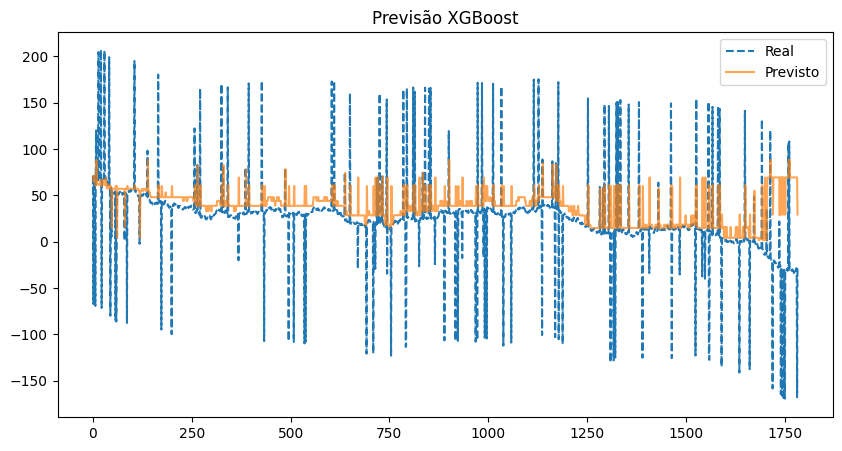

In [15]:
# Gráfico Real x Previsto
plt.figure(figsize=(10, 5))
plt.plot(test_results['Actual'], label='Real', linestyle='dashed')
plt.plot(test_results['Predicted'], label='Previsto', alpha=0.7)
plt.legend()
plt.title(f'Previsão XGBoost')
plt.show()

# 4. Análise dos erros

In [16]:
results = pd.concat([train_results, test_results])
results['Error'] = results['Actual'] - results['Predicted']

Q1 = results['Actual'].quantile(0.25)
Q3 = results['Actual'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = results[(results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)]
outliers

,Actual,Predicted,Error
2,-135.982152,4.171227,-140.153378
57,-148.766783,1.683555,-150.450338
122,-198.129656,1.683555,-199.813211
307,-138.878420,4.171227,-143.049646
347,-138.354008,4.171227,-142.525234
...,...,...,...
1740,-164.580277,69.254852,-233.835129
1743,-166.194379,69.254852,-235.449231
1747,-170.551737,60.045925,-230.597662
1750,-169.276030,69.254852,-238.530882


In [17]:
# Identifica os outliers
results['Outlier'] = (results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)
results.head()

,Actual,Predicted,Error,Outlier
0,0.358484,4.171227,-3.812743,False
1,1.005977,4.171227,-3.165250,False
2,-135.982152,4.171227,-140.153378,True
3,140.804575,29.286537,111.518038,False
4,2.066599,61.036060,-58.969462,False


In [18]:
# Teste de Mann-Whitney
from scipy.stats import mannwhitneyu

# Separa os erros dos dois grupos
erros_outliers = results[results['Outlier']]['Error']
erros_normais = results[~results['Outlier']]['Error']

# Aplicação do teste de Mann-Whitney
stat, p = mannwhitneyu(erros_outliers, erros_normais, alternative='greater')

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 480176.0
Valor-p: 0.0373949300597858
Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.


In [19]:
# Teste de Kruskal-Wallis
from scipy.stats import kruskal

# Classificação dos pontos
results['Grupo'] = 'normal'
results.loc[results['Actual'] < lower_bound, 'Grupo'] = 'outlier_negativo'
results.loc[results['Actual'] > upper_bound, 'Grupo'] = 'outlier_positivo'

# Separa os erros por grupo
erros_normais = results[results['Grupo'] == 'normal']['Error']
erros_outliers_neg = results[results['Grupo'] == 'outlier_negativo']['Error']
erros_outliers_pos = results[results['Grupo'] == 'outlier_positivo']['Error']

# Aplicação do teste de Kruskal-Wallis
stat, p = kruskal(erros_normais, erros_outliers_neg, erros_outliers_pos)

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 446.36617283700616
Valor-p: 1.1825434701320846e-97
Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.


In [20]:
# Análise da correlação de Spearman
from scipy.stats import spearmanr

# Calcular a correlação de Spearman
correlacao, p_valor = spearmanr(results['Outlier'], results['Error'])

# Exibir resultados
print(f"Correlação: {correlacao}")
print(f"Valor-p: {p_valor}")

if p_valor < 0.05:
    print("Existe uma relação significativa entre outliers e a magnitude do erro.")
else:
    print("Não há evidência estatística de que os outliers impactam significativamente os erros.")

Correlação: 0.02311655075291414
Valor-p: 0.0747838231670689
Não há evidência estatística de que os outliers impactam significativamente os erros.
